In [6]:
import pandas as pd
import json
from environs import Env
from graph_functions import query_to_df,start_graph_session, start_graph_session_crashdown
from IPython.display import Image


env = Env()
session = start_graph_session(env) 
#session = start_graph_session_crashdown(env) 

37687


#### In this notebook:

- Review all available breast cancer GWAS
- Explore GWAS -> Pathways
    - comparison between full/ER+/ER-
- Explore GWAS -> Tissue
    - gwas significant genes that are also expressed in breast tissue > 1 TPM
    - 98/167 genes from 3 breast cancer GWAS are expressed in Breast tissue


- MR     

## Get GWAS with available full summary data

In [2]:
query="""
MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)
where toLower(gwas.trait) contains "breast"
and not(toLower(gwas.trait) contains "baby") and not(toLower(gwas.trait) contains "mother")
return distinct gwas.trait, gwas.id, gwas_to_variant.samplesize as SampleSize,
toInteger(gwas.ncase) as N_case, toInteger(gwas.ncontrol) as N_control, gwas.author, 
count(gwas_to_variant.pval) as signifSNPs
order by gwas_to_variant.samplesize desc
"""
df = query_to_df(session, query)
all_bc_gwas = list(df['gwas.id'])
df

# We are going to focus on 1126, 1127, 1128 for our main exploration


MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)
where toLower(gwas.trait) contains "breast"
and not(toLower(gwas.trait) contains "baby") and not(toLower(gwas.trait) contains "mother")
return distinct gwas.trait, gwas.id, gwas_to_variant.samplesize as SampleSize,
toInteger(gwas.ncase) as N_case, toInteger(gwas.ncontrol) as N_control, gwas.author, 
count(gwas_to_variant.pval) as signifSNPs
order by gwas_to_variant.samplesize desc



,gwas.trait,gwas.id,SampleSize,N_case,N_control,gwas.author,signifSNPs
0,Diagnoses - main ICD10: C50 Malignant neoplasm...,ukb-a-519,337199,5510,331689,Neale,7
1,Cancer code self-reported: breast cancer,ukb-a-55,337159,7480,329679,Neale,17
2,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,228951,122977,105974,Michailidou K,141
3,ER+ Breast cancer (Combined Oncoarray; iCOGS; ...,ieu-a-1127,175475,69501,105974,Michailidou K,107
4,ER- Breast cancer (Combined Oncoarray; iCOGS; ...,ieu-a-1128,127442,21468,105974,Michailidou K,37
5,Breast cancer (Oncoarray),ieu-a-1129,106776,61282,45494,Michailidou K,60
6,Breast cancer (iCOGS),ieu-a-1130,89677,46785,42892,Michailidou K,47
7,ER+ Breast cancer (Oncoarray),ieu-a-1132,83691,38197,45494,Michailidou K,58
8,ER+ Breast cancer (iCOGS),ieu-a-1133,69970,27078,42892,Michailidou K,41
9,ER- Breast cancer (Oncoarray),ieu-a-1135,55149,9655,45494,Michailidou K,13


In [3]:
# get unique genes from all GWAS
query="""
MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)
WHERE gwas.id in {}
return distinct gene.name
order by gene.name

""".format(['ieu-a-1126', 'ieu-a-1127', 'ieu-a-1128'])
df = query_to_df(session, query)
df.shape


MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)
WHERE gwas.id in ['ieu-a-1126', 'ieu-a-1127', 'ieu-a-1128']
return distinct gene.name
order by gene.name




(167, 1)

## Explore gwas->variant->gene->protein->pathway

In [4]:
# for major GWAS

def get_gwas_to_pathway(GWAS_ID):
    query = """
    MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein) -[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) 
    WHERE gwas.id = '{gwas_id}' AND gwas_to_variant.pval < 1e-08 
    AND gene.name is not null 
    RETURN gwas.id, gwas_to_variant.beta, gwas_to_variant.pval, gwas_to_variant.samplesize as sampleSize,
           variant.name, gene.name, protein.uniprot_id, 
           collect (pathway.name) as Pathways, count (pathway.name) as N_pathways 
    ORDER BY gwas_to_variant.pval
    """.format(gwas_id=GWAS_ID)

    df = query_to_df(session, query)
    return df

bc_all_gwas_to_path = get_gwas_to_pathway(GWAS_ID = 'ieu-a-1126')
print(bc_all_gwas_to_path.shape[0])
bc_er_pos_gwas_to_path = get_gwas_to_pathway(GWAS_ID = 'ieu-a-1127')
print(bc_er_pos_gwas_to_path.shape[0])
bc_er_neg_gwas_to_path = get_gwas_to_pathway(GWAS_ID = 'ieu-a-1128')
print(bc_er_neg_gwas_to_path.shape[0])



    MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein) -[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) 
    WHERE gwas.id = 'ieu-a-1126' AND gwas_to_variant.pval < 1e-08 
    AND gene.name is not null 
    RETURN gwas.id, gwas_to_variant.beta, gwas_to_variant.pval, gwas_to_variant.samplesize as sampleSize,
           variant.name, gene.name, protein.uniprot_id, 
           collect (pathway.name) as Pathways, count (pathway.name) as N_pathways 
    ORDER BY gwas_to_variant.pval
    
53

    MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein) -[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) 
    WHERE gwas.id = 'ieu-a-1127' AND gwas_to_variant.pval < 1e-08 
    AND gene.name is not null 
    RETURN gwas.id, gwas_to_variant.be

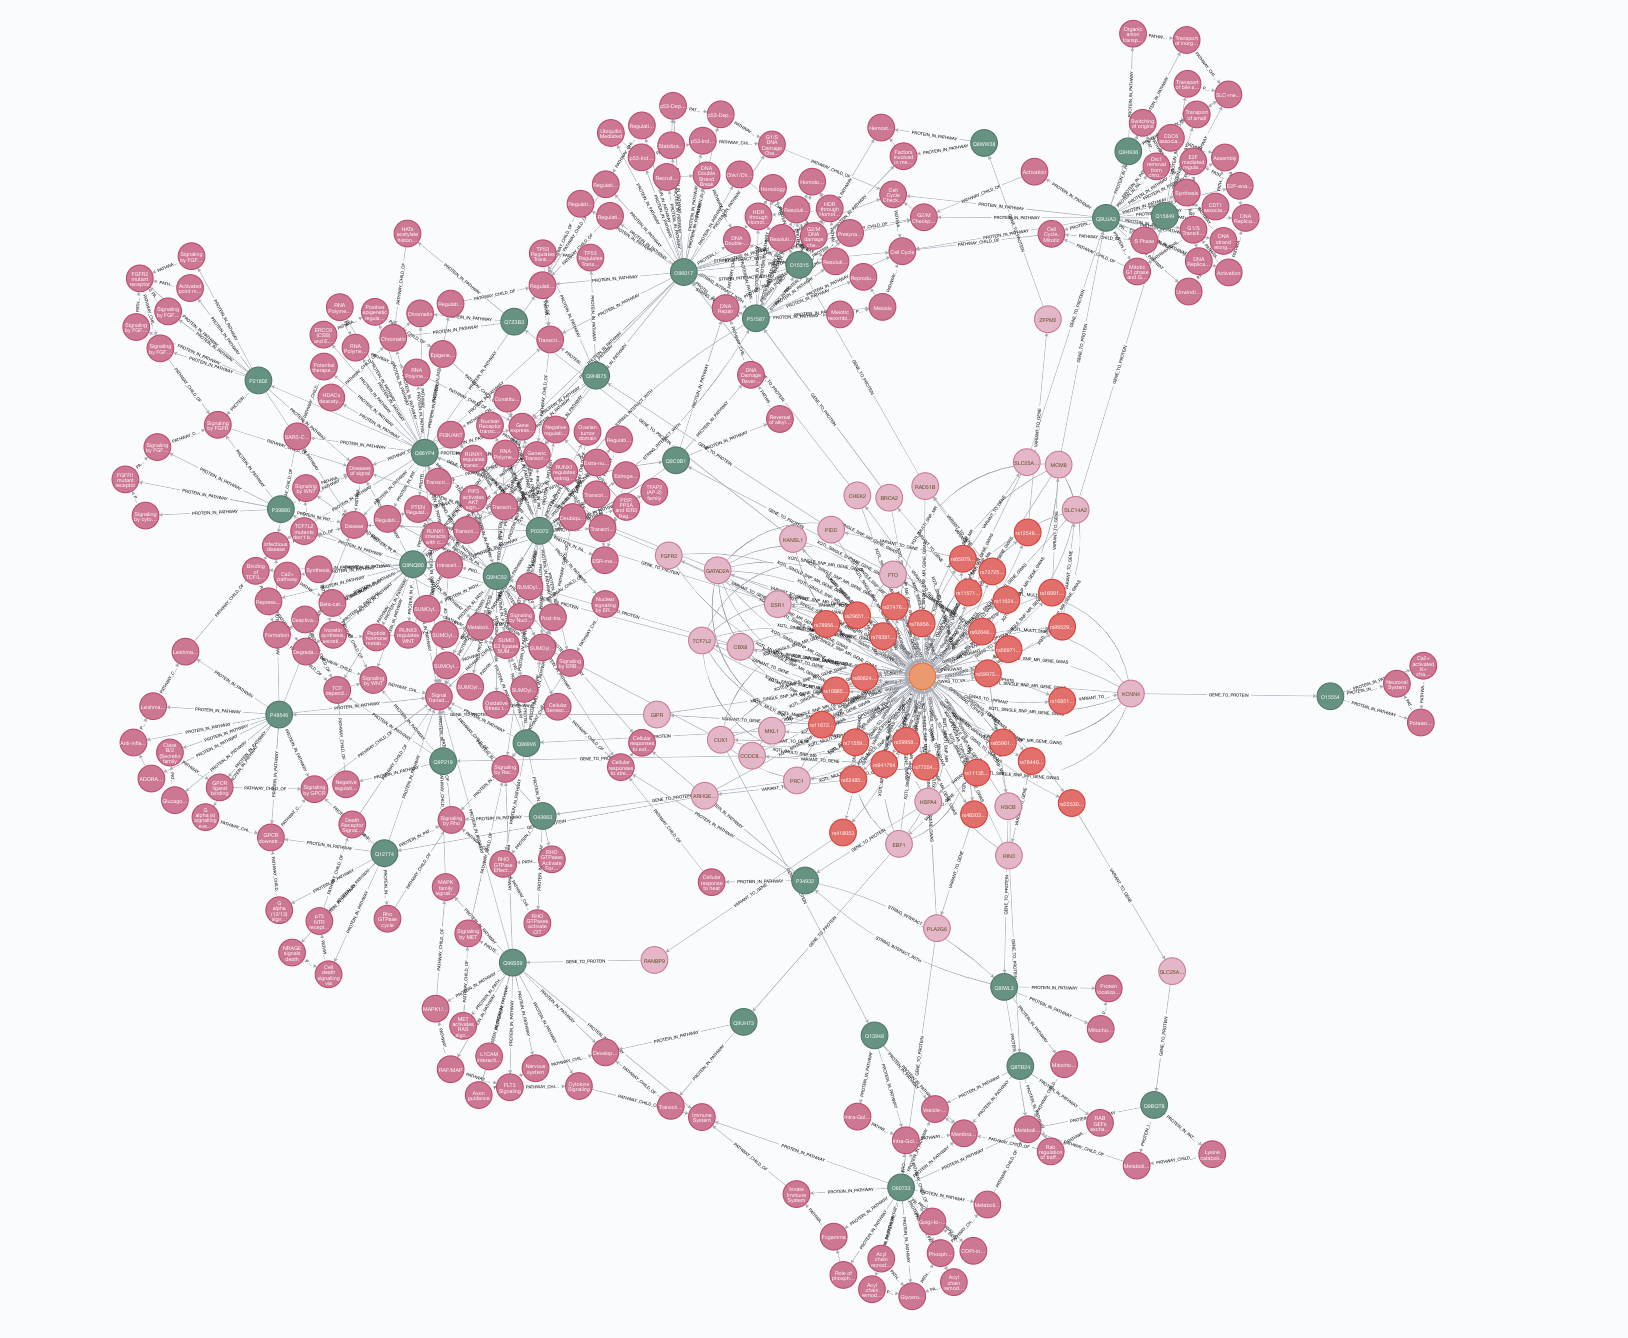

In [5]:
# for neo4j browser to make a viz

#MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein) -[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) 
#WHERE gwas.id = 'ieu-a-1126' AND gwas_to_variant.pval < 1e-08 
#AND gene.name is not null 
#RETURN gwas, gwas_to_variant, variant,variant_to_gene,  gene, gene_to_protein, protein, protein_in_pathway, pathway

Image(filename = "figures/ieu-a-1126_pathways.png")

In [6]:
bc_all_gwas_to_path

,gwas.id,gwas_to_variant.beta,gwas_to_variant.pval,sampleSize,variant.name,gene.name,protein.uniprot_id,Pathways,N_pathways
0,ieu-a-1126,-0.2030,1.000000e-200,228951,rs7895676,FGFR2,P21802,"[Signaling by FGFR2 fusions, Signaling by FGFR...",9
1,ieu-a-1126,-0.0968,6.501297e-42,228951,rs11624333,RAD51B,O15315,[Factors involved in megakaryocyte development...,12
2,ieu-a-1126,0.1206,9.038576e-35,228951,rs5995875,MKL1,Q969V6,"[Post-translational protein modification, RHO ...",9
3,ieu-a-1126,-0.0717,4.680584e-31,228951,rs11135046,EBF1,Q9UH73,[Transcriptional regulation of white adipocyte...,2
4,ieu-a-1126,0.0663,1.307073e-26,228951,rs2747652,ESR1,P03372,"[Estrogen-dependent gene expression, Extra-nuc...",34
5,ieu-a-1126,-0.0624,3.500258e-23,228951,rs62048402,FTO,Q9C0B1,[Reversal of alkylation damage by DNA dioxygen...,3
6,ieu-a-1126,-0.0651,4.046691e-21,228951,rs2853669,TERT,O14746,"[Chromosome Maintenance, Formation of the beta...",9
7,ieu-a-1126,-0.0615,2.381771e-20,228951,rs2506889,PEX14,O75381,"[Protein localization, Class I peroxisomal mem...",7
8,ieu-a-1126,-0.0586,3.874360e-20,228951,rs1685191,KCNN4,O15554,"[Potassium Channels, Ca2+ activated K+ channel...",3
9,ieu-a-1126,0.0567,9.074026e-19,228951,rs6787391,ITPR1,Q14643,"[Signaling by the B Cell Receptor (BCR), Antig...",50


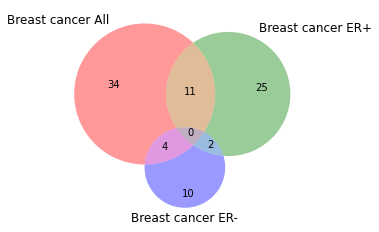

In [7]:
from matplotlib_venn import venn3
from matplotlib import pyplot as plt
%matplotlib inline

# variants overlap between 3 GWAS
venn3([set(bc_all_gwas_to_path["variant.name"]),
       set(bc_er_pos_gwas_to_path["variant.name"]), 
       set(bc_er_neg_gwas_to_path["variant.name"])],
      set_labels=('Breast cancer All', 
                  'Breast cancer ER+', 
                  'Breast cancer ER-'))
plt.show()

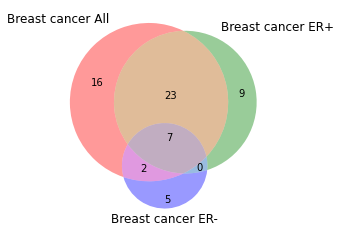

In [8]:
#genes overlap between 3 GWAS
venn3([set(bc_all_gwas_to_path["gene.name"]), 
       set(bc_er_pos_gwas_to_path["gene.name"]), 
       set(bc_er_neg_gwas_to_path["gene.name"])],
      set_labels=('Breast cancer All',
                  'Breast cancer ER+', 
                  'Breast cancer ER-'))
plt.show()

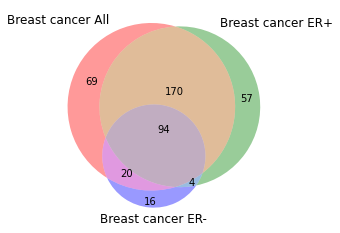

In [9]:
# pathways overlap
def flatten(nested_list):
    flat_list = [item for sublist in list(nested_list) for item in sublist]
    return set(flat_list)

venn3([flatten(bc_all_gwas_to_path["Pathways"]),
      flatten(bc_er_pos_gwas_to_path["Pathways"]), 
      flatten(bc_er_neg_gwas_to_path["Pathways"])],
      set_labels=('Breast cancer All', 
                  'Breast cancer ER+', 
                  'Breast cancer ER-'))
plt.show()

## Explore gwas->variant->gene->tissue 

In [10]:

# find GWAS variants pval < 1e-05, map to genes, get expression data,
# find which are expressed in Breast tissue, with TPM > 1

def get_gwas_to_tissue(GWAS_ID):
    query = """
    MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_tissue:EXPRESSED_IN]->(tissue:Tissue) 
    WHERE gwas.id in {}
    AND gwas_to_variant.pval < 1e-05 
    AND gene.name is not null 
    AND gene_to_tissue.tpm > 1
    AND  tissue.name = "Breast - Mammary Tissue"
    RETURN gwas.id, gwas_to_variant.beta, gwas_to_variant.pval, 
    variant.name, gene.name, 
    gene_to_tissue.tpm as TPM, tissue.name
    ORDER BY TPM desc
    """.format(GWAS_ID)

    df = query_to_df(session, query)
    return df

bc_all_exp = get_gwas_to_tissue(GWAS_ID = ['ieu-a-1126','ieu-a-1127','ieu-a-1128'] )
bc_all_exp

# these are genes that have evidence of effect on BC in GWAS, and are also expressed in breast tissue


    MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_tissue:EXPRESSED_IN]->(tissue:Tissue) 
    WHERE gwas.id in ['ieu-a-1126', 'ieu-a-1127', 'ieu-a-1128']
    AND gwas_to_variant.pval < 1e-05 
    AND gene.name is not null 
    AND gene_to_tissue.tpm > 1
    AND  tissue.name = "Breast - Mammary Tissue"
    RETURN gwas.id, gwas_to_variant.beta, gwas_to_variant.pval, 
    variant.name, gene.name, 
    gene_to_tissue.tpm as TPM, tissue.name
    ORDER BY TPM desc
    


,gwas.id,gwas_to_variant.beta,gwas_to_variant.pval,variant.name,gene.name,TPM,tissue.name
0,ieu-a-1126,0.0450,1.205869e-11,rs12487185,TGFBR2,273.1000,Breast - Mammary Tissue
1,ieu-a-1127,0.0624,5.783623e-15,rs17838698,TGFBR2,273.1000,Breast - Mammary Tissue
2,ieu-a-1127,0.0918,2.332975e-08,rs35383942,PHLDA3,118.1500,Breast - Mammary Tissue
3,ieu-a-1126,0.1010,3.793150e-13,rs35383942,PHLDA3,118.1500,Breast - Mammary Tissue
4,ieu-a-1127,-0.0740,4.796230e-12,rs12110303,ARRDC3,73.8650,Breast - Mammary Tissue
...,...,...,...,...,...,...,...
162,ieu-a-1126,0.1046,1.612130e-63,rs7626742,NEK10,1.2100,Breast - Mammary Tissue
163,ieu-a-1127,0.1148,3.278687e-54,rs490706,NEK10,1.2100,Breast - Mammary Tissue
164,ieu-a-1127,0.0519,1.265028e-11,rs4971059,TRIM46,1.0800,Breast - Mammary Tissue
165,ieu-a-1126,0.0424,4.825030e-11,rs4971059,TRIM46,1.0800,Breast - Mammary Tissue


In [11]:
# add expression level categories
bc_all_exp['tpm_category'] = ''
bc_all_exp

for ind in bc_all_exp.index:
    if bc_all_exp['TPM'][ind] >= 100:
        bc_all_exp['tpm_category'][ind] = "high"
    elif bc_all_exp['TPM'][ind] < 100 and bc_all_exp['TPM'][ind] > 10 :
        bc_all_exp['tpm_category'][ind] = "medium"
    elif bc_all_exp['TPM'][ind] <= 10:
        bc_all_exp['tpm_category'][ind] = "low"
        
bc_all_exp


/Users/ny19205/opt/anaconda3/envs/neo4j_build/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/ny19205/opt/anaconda3/envs/neo4j_build/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/ny19205/opt/anaconda3/envs/neo4j_build/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

,gwas.id,gwas_to_variant.beta,gwas_to_variant.pval,variant.name,gene.name,TPM,tissue.name,tpm_category
0,ieu-a-1126,0.0450,1.205869e-11,rs12487185,TGFBR2,273.1000,Breast - Mammary Tissue,high
1,ieu-a-1127,0.0624,5.783623e-15,rs17838698,TGFBR2,273.1000,Breast - Mammary Tissue,high
2,ieu-a-1127,0.0918,2.332975e-08,rs35383942,PHLDA3,118.1500,Breast - Mammary Tissue,high
3,ieu-a-1126,0.1010,3.793150e-13,rs35383942,PHLDA3,118.1500,Breast - Mammary Tissue,high
4,ieu-a-1127,-0.0740,4.796230e-12,rs12110303,ARRDC3,73.8650,Breast - Mammary Tissue,medium
...,...,...,...,...,...,...,...,...
162,ieu-a-1126,0.1046,1.612130e-63,rs7626742,NEK10,1.2100,Breast - Mammary Tissue,low
163,ieu-a-1127,0.1148,3.278687e-54,rs490706,NEK10,1.2100,Breast - Mammary Tissue,low
164,ieu-a-1127,0.0519,1.265028e-11,rs4971059,TRIM46,1.0800,Breast - Mammary Tissue,low
165,ieu-a-1126,0.0424,4.825030e-11,rs4971059,TRIM46,1.0800,Breast - Mammary Tissue,low


In [12]:
bc_all_exp.to_csv("query_results/bc_gwas_expressed_in_breastTissue.tsv", sep="\t", index=False)

In [13]:
gene_list = list(set(bc_all_exp['gene.name']))
len(gene_list)

98

In [14]:
# map to their protein product
query="""
MATCH  (gene:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein) 
WHERE gene.name in {}
RETURN  gene.name, protein.name
""".format(gene_list)
df=query_to_df(session, query)
df



MATCH  (gene:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein) 
WHERE gene.name in ['PEX14', 'NRIP1', 'ELL', 'RP11-134G8.8', 'PRC1', 'VGLL3', 'CDYL2', 'ABO', 'TGFBR2', 'RCCD1', 'N4BP2L1', 'CASP8', 'KCNN4', 'PLA2G6', 'PDE4D', 'CBX8', 'AMFR', 'TTC28', 'MLLT10', 'SCAMP2', 'LSP1', 'MTMR11', 'ITPR1', 'ZMIZ1', 'RIN3', 'ANKLE1', 'FAM46A', 'KANSL1', 'FILIP1L', 'TRIM46', 'SETBP1', 'ADCY3', 'CUX1', 'SSBP4', 'ARHGEF5', 'ATG10', 'SLC25A22', 'L3MBTL3', 'GRHL1', 'OTUD7B', 'VPS33B', 'FOXP1', 'PIDD', 'TLR1', 'MYEOV', 'PIK3R3', 'PHLDA3', 'TACC2', 'TCF7L2', 'MCM8', 'ADSSL1', 'EBF1', 'HSPA4', 'SF3B4', 'LGR6', 'FGFR2', 'NEK10', 'NREP', 'ASTN2', 'CDCA7L', 'ZNF184', 'USHBP1', 'RPL23AP53', 'ESR1', 'KRTCAP2', 'ZBTB38', 'CREB5', 'ULK3', 'RAD51B', 'FAM175A', 'ATXN7', 'DNAJC1', 'SV2A', 'OR2A1-AS1', 'ARRDC3', 'FTO', 'TET2', 'LINC-PINT', 'GIPR', 'HSCB', 'CHEK2', 'ADCY9', 'SUB1', 'MDM4', 'ZFPM2', 'MKL1', 'STXBP4', 'BABAM1', 'CMSS1', 'RNF115', 'GAREM', 'RANBP9', 'GATAD2A', 'MAGI3', 'CDKN2B', 'LMX1B', 'CCDC

,gene.name,protein.name
0,NRIP1,P48552
1,RCCD1,A6NED2
2,PRC1,O43663
3,VPS33B,Q9H267
4,LMX1B,O60663
...,...,...
89,RNF115,Q9Y4L5
90,MLLT10,P55197
91,PHLDA3,Q9Y5J5
92,DNAJC1,Q96KC8


In [15]:
# take genes expressed in Breast tissues and  collect where they are also expressed
# not really sure what to do with this information

genes_test=list(bc_all_exp['gene.name'])

query = """
    MATCH (gene:Gene)-[gene_to_tissue:EXPRESSED_IN]->(tissue:Tissue) 
    WHERE gene.name in {} 
    AND gene_to_tissue.tpm > 1
    WITH gene_to_tissue, gene, tissue
    ORDER BY gene_to_tissue.tpm  desc, tissue.name
    RETURN gene.name, count(tissue.name) as N_tissues, 
    collect(tissue.name) as Tissues, collect(gene_to_tissue.tpm) as TPM_vals
    """.format(genes_test)

df = query_to_df(session, query)
df


    MATCH (gene:Gene)-[gene_to_tissue:EXPRESSED_IN]->(tissue:Tissue) 
    WHERE gene.name in ['TGFBR2', 'TGFBR2', 'PHLDA3', 'PHLDA3', 'ARRDC3', 'SCAMP2', 'BABAM1', 'SF3B4', 'ADCY3', 'ADCY3', 'SUB1', 'ULK3', 'SSBP4', 'KRTCAP2', 'KRTCAP2', 'AMFR', 'TCF7L2', 'TCF7L2', 'ZMIZ1', 'ZMIZ1', 'ZMIZ1', 'ZMIZ1', 'EBF1', 'EBF1', 'EBF1', 'RANBP9', 'RANBP9', 'HSPA4', 'HSPA4', 'PIK3R3', 'PIK3R3', 'MKL1', 'MKL1', 'MKL1', 'KANSL1', 'LSP1', 'LSP1', 'PLA2G6', 'PLA2G6', 'DNAJC1', 'PEX14', 'PEX14', 'PEX14', 'GATAD2A', 'FILIP1L', 'FILIP1L', 'ELL', 'HSCB', 'HSCB', 'N4BP2L1', 'N4BP2L1', 'PIDD', 'MDM4', 'MLLT10', 'MLLT10', 'MLLT10', 'NRIP1', 'RNF115', 'RNF115', 'GRHL1', 'VPS33B', 'ZBTB38', 'ZBTB38', 'USHBP1', 'ITPR1', 'ITPR1', 'LINC-PINT', 'ATXN7', 'ATXN7', 'FOXP1', 'SLC25A22', 'VGLL3', 'FAM46A', 'FAM46A', 'FAM46A', 'MTMR11', 'CMSS1', 'CMSS1', 'CDKN2B', 'ADCY9', 'TTC28', 'TTC28', 'SETBP1', 'SETBP1', 'RIN3', 'TACC2', 'RP11-134G8.8', 'RP11-134G8.8', 'RCCD1', 'CCDC88C', 'CCDC88C', 'CCDC88C', 'CUX1', 'CUX1', 'GIPR

,gene.name,N_tissues,Tissues,TPM_vals
0,LSP1,42,"[Whole Blood, Cells - EBV-transformed lymphocy...","[418.8, 236.7, 165.85, 105.15, 57.02, 53.04, 4..."
1,PHLDA3,51,"[Nerve - Tibial, Colon - Sigmoid, Adipose - Su...","[352.75, 195.0, 183.15, 118.15, 117.8, 113.9, ..."
2,TGFBR2,52,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[316.8, 296.1, 273.1, 260.05, 252.3, 244.4, 22..."
3,ADSSL1,50,"[Muscle - Skeletal, Artery - Tibial, Artery - ...","[311.15, 63.53, 58.37, 54.49, 52.2, 44.51, 19...."
4,ULK3,52,"[Brain - Cerebellum, Brain - Cerebellar Hemisp...","[259.2, 249.9, 135.0, 130.0, 116.0, 105.7, 104..."
...,...,...,...,...
93,ATG10,51,"[Testis, Skin - Not Sun Exposed (Suprapubic), ...","[6.895, 3.824, 3.7855, 3.7560000000000002, 3.6..."
94,RPL23AP53,50,"[Testis, Artery - Tibial, Ovary, Artery - Aort...","[6.215, 6.184, 6.021, 5.747000000000001, 5.654..."
95,LMX1B,8,"[Breast - Mammary Tissue, Skin - Sun Exposed (...","[5.348, 3.0789999999999997, 2.763, 2.68, 2.498..."
96,RAD51B,21,"[Uterus, Cells - EBV-transformed lymphocytes, ...","[5.187, 4.0765, 3.2539999999999996, 3.19100000..."


In [16]:
# e.g. just try one gene
query = """
    MATCH (gene:Gene)-[gene_to_tissue:EXPRESSED_IN]->(tissue:Tissue) 
    WHERE gene.name = 'LMX1B' 
    AND gene_to_tissue.tpm > 1
    RETURN gene.name, gene_to_tissue.tpm, tissue.name 
    ORDER BY gene_to_tissue.tpm desc
    """

df = query_to_df(session, query)
df


    MATCH (gene:Gene)-[gene_to_tissue:EXPRESSED_IN]->(tissue:Tissue) 
    WHERE gene.name = 'LMX1B' 
    AND gene_to_tissue.tpm > 1
    RETURN gene.name, gene_to_tissue.tpm, tissue.name 
    ORDER BY gene_to_tissue.tpm desc
    


,gene.name,gene_to_tissue.tpm,tissue.name
0,LMX1B,5.3480,Breast - Mammary Tissue
1,LMX1B,3.0790,Skin - Sun Exposed (Lower leg)
2,LMX1B,2.7630,Kidney - Cortex
3,LMX1B,2.6800,Testis
4,LMX1B,2.4980,Skin - Not Sun Exposed (Suprapubic)
5,LMX1B,2.4345,Brain - Substantia nigra
6,LMX1B,1.1880,Heart - Atrial Appendage
7,LMX1B,1.0270,Minor Salivary Gland
